<a href="https://colab.research.google.com/github/pavankumarchakali-25/PlantDiagnosisSystem/blob/main/plantdiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os

kaggle_credentials = {
    "username": "pavanchakali",
    "key": "445bb026d8313c9672ad26ad47fbd402"
}

# Create kaggle.json directly in Colab
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_credentials, f)

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

print("✅ Kaggle API Key Set Successfully!")


✅ Kaggle API Key Set Successfully!


In [2]:
!kaggle datasets download -d emmarex/plantdisease --unzip


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 642M/658M [00:03<00:00, 203MB/s]
100% 658M/658M [00:03<00:00, 188MB/s]


In [3]:
import os

# List files in the current directory
print(os.listdir("./"))


['.config', 'plantvillage', 'PlantVillage', 'sample_data']


In [4]:
dataset_path = "./PlantVillage"
print(os.listdir(dataset_path))


['Potato___Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Potato___healthy', 'Tomato_Late_blight']


In [5]:
!pip install scikit-fuzzy tensorflow opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.2 MB/s eta 0:00:00


In [6]:
import os
import cv2
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import pickle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load Pretrained CNN (VGG16) for Deep Feature Extraction
base_model = VGG16(weights="imagenet")
model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc1").output)

# Function to Extract Features from Image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)

    # Extract color features (mean RGB)
    img_cv = cv2.imread(img_path)
    avg_color = img_cv.mean(axis=(0, 1))  # Mean of (B, G, R)

    # Extract texture features (using Laplacian)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    texture = cv2.Laplacian(gray, cv2.CV_64F).var()

    return {"features": features.flatten(), "color": avg_color, "texture": texture}

# Load Dataset Images
dataset_path = "./PlantVillage"
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(".jpg")]

# Train on first 20 images (modify as needed)
train_data = []
for img_file in image_files[:20]:
    features = extract_features(img_file)
    label = "healthy" if "healthy" in img_file else "diseased"
    train_data.append({"features": features, "label": label})

# Define Fuzzy Logic Variables
# Define Fuzzy Logic Variables
color = ctrl.Antecedent(np.arange(0, 256, 1), "color")
texture = ctrl.Antecedent(np.arange(0, 5000, 1), "texture")
health = ctrl.Consequent(np.arange(0, 100, 1), "health", defuzzify_method="centroid")  # ✅ Ensure it's added

# Define Membership Functions
color["low"] = fuzz.trimf(color.universe, [0, 0, 128])
color["high"] = fuzz.trimf(color.universe, [128, 255, 255])
texture["low"] = fuzz.trimf(texture.universe, [0, 0, 2500])
texture["high"] = fuzz.trimf(texture.universe, [2500, 5000, 5000])
health["diseased"] = fuzz.trimf(health.universe, [0, 0, 50])
health["healthy"] = fuzz.trimf(health.universe, [50, 100, 100])

# ✅ Ensure health is added to the control system
health_ctrl = ctrl.ControlSystem([])

# Define Fuzzy Rules
rule1 = ctrl.Rule(color["low"] & texture["high"], health["diseased"])
rule2 = ctrl.Rule(color["high"] & texture["low"], health["healthy"])
rule3 = ctrl.Rule(color["low"] & texture["low"], health["diseased"])
rule4 = ctrl.Rule(color["high"] & texture["high"], health["healthy"])

# ✅ Add rules **before** initializing the system
health_ctrl.addrule(rule1)
health_ctrl.addrule(rule2)
health_ctrl.addrule(rule3)
health_ctrl.addrule(rule4)

# ✅ Recreate the control system
health_system = ctrl.ControlSystemSimulation(health_ctrl)

# 🚀 Force Initialize Outputs
health_system.input["color"] = 100  # Dummy value
health_system.input["texture"] = 2000  # Dummy value
health_system.compute()  # 🚨 Compute once to initialize outputs

print("✅ Checking Available Outputs AFTER compute():", health_system.output.keys())


# ✅ Check Outputs Again
print("✅ Available Outputs AFTER defining health:", health_system.output.keys())
# Debug: Check if health is registered in the control system
print("✅ Checking Consequents in Control System:", list(health_ctrl.consequents))
print("✅ Checking Available Outputs in Simulation:", health_system.output.keys())

# Save Model
with open("PlantHealthFIS.pkl", "wb") as f:
    pickle.dump(health_system, f)

print("✅ Fuzzy Model Trained and Saved as 'PlantHealthFIS.pkl'!")




553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ Checking Available Outputs AFTER compute(): dict_keys(['health'])
✅ Available Outputs AFTER defining health: dict_keys(['health'])
✅ Checking Consequents in Control System: [Consequent: health]
✅ Checking Available Outputs in Simulation: dict_keys(['health'])
✅ Fuzzy Model Trained and Saved as 'PlantHealthFIS.pkl'!


In [7]:
import urllib.request

# Replace with your image URL
image_url = "https://thumbs.dreamstime.com/b/green-leaf-13924003.jpg"

# Define save path
save_path = "./PlantVillage/test-leaf.jpg"

# Download the image
urllib.request.urlretrieve(image_url, save_path)

print("✅ Image downloaded successfully!")


✅ Image downloaded successfully!


✅ Available Outputs AFTER loading: dict_keys(['health'])
✅ Healthy Plant


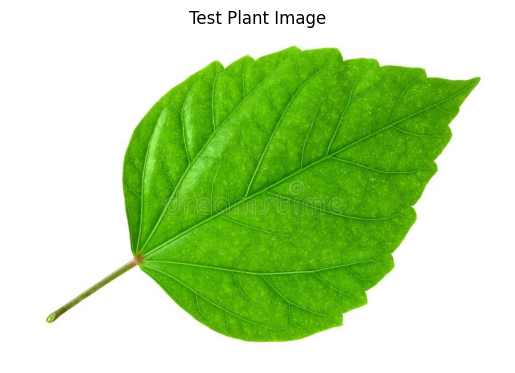

In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to Extract Features from Image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Extract color features (mean RGB)
    img_cv = cv2.imread(img_path)
    avg_color = img_cv.mean(axis=(0, 1))  # Mean of (B, G, R)

    # Extract texture features (using Laplacian)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    texture = cv2.Laplacian(gray, cv2.CV_64F).var()

    return {"color": avg_color, "texture": texture}

# Load trained fuzzy model
with open("PlantHealthFIS.pkl", "rb") as f:
    health_system = pickle.load(f)

# Debugging: Check if "health" is present
print("✅ Available Outputs AFTER loading:", health_system.output.keys())  # Should include 'health'

# Select a test image
test_image = "./PlantVillage/test-leaf.jpg"

# Extract features from the test image
test_features = extract_features(test_image)

# Set fuzzy inputs
health_system.input["color"] = test_features["color"].mean()
health_system.input["texture"] = test_features["texture"]

# Compute fuzzy output
health_system.compute()

# Get result safely
if "health" in health_system.output:
    result = health_system.output["health"]
else:
    raise ValueError("❌ ERROR: 'health' output not found in fuzzy system!")

# Show Prediction
if result < 50:
    print("❌ Diseased Plant")
else:
    print("✅ Healthy Plant")

# Show test image
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.title("Test Plant Image")
plt.show()
